# Chatting bot Topic Clustering

<b style = "color:red">Important!</b>


**Check the setup.ipynb to find the modules needed**

Dataset url https://github.com/google-research-datasets/Taskmaster/raw/master/TM-1-2019

In [1]:
__author__ = ["Haolin Pan", "Riade Benbaki"]
__version__ = "École Polytechnique, 2020/3/31"
__data__ = "https://github.com/riadeb/Topic_Clustering"

# Set up

In [1]:
# set up
from collections import defaultdict
import numpy as np
import pandas as pd
import requests
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import metrics

from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score

Using TensorFlow backend.


### To use GPU with TF 
Execute following cell and check whether TF detects your GPU or not

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

### The local .py

In [3]:
from src.topic_clustering_model import Topic_clustering

In [4]:
os.getcwd()


'/Data/riade/TC_git/training notebooks'

# Initialization

In [5]:
TCM = Topic_clustering("./src/trained weigths/topic_clustering")

module use loaded
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


module elmo loaded
module nnlm loaded
Gnews Swivel loaded
/Data/riade/TC_git/training notebooks
Loaded weights for model elmo
/Data/riade/TC_git/training notebooks
Loaded weights for model use


# Data

### Raw Data

In [13]:
TCM.data[:2]

[{'conversation_id': 'dlg-00055f4e-4a46-48bf-8d99-4e477663eb23',
  'instruction_id': 'restaurant-table-2',
  'utterances': [{'index': 0,
    'speaker': 'USER',
    'text': "Hi, I'm looking to book a table for Korean fod."},
   {'index': 1,
    'speaker': 'ASSISTANT',
    'text': 'Ok, what area are you thinking about?'},
   {'index': 2,
    'speaker': 'USER',
    'text': 'Somewhere in Southern NYC, maybe the East Village?',
    'segments': [{'start_index': 13,
      'end_index': 49,
      'text': 'Southern NYC, maybe the East Village',
      'annotations': [{'name': 'restaurant_reservation.location.restaurant.accept'}]},
     {'start_index': 13,
      'end_index': 25,
      'text': 'Southern NYC',
      'annotations': [{'name': 'restaurant_reservation.location.restaurant.accept'}]}]},
   {'index': 3,
    'speaker': 'ASSISTANT',
    'text': "Ok, great.  There's Thursday Kitchen, it has great reviews.",
    'segments': [{'start_index': 20,
      'end_index': 35,
      'text': 'Thursday Ki

We can see there are more information in the raw data, we use `data_prerocessing` to select the phrases as `X` and topics as `y`

In [5]:
TCM.data_precessing()

The numbers of samples we take from the original data: 
auto : 	 1161
coffee : 	 1376
movie : 	 1305
pizza : 	 1400
restaurant : 	 1300
uber : 	 1098
non-opening : 	 1400
Total:	  9040


In [6]:
TCM.X[:10]

array(["Hi, I'm looking to book a table for Korean fod.", 'Yes.',
       'Hi I would like to see if the Movie What Men Want is playing here.',
       'That movie is showing at 4, 5, and 8pm.',
       'I want to watch avengers endgame', 'I am afraid so ',
       'I want to order a pizza from Bertuccis in Chelmsford, MA',
       'unfortunately bertuccis has run out of broccoli and so are not offering the silano style pizza today',
       "Hi I'd like to order two large pizzas.",
       'thank you very much. Is there anything else I can get for you?'],
      dtype='<U434')

In [16]:
TCM.y[:10]

array([[0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0]])

# Modeling

We choosed four different kinds of modeling structure to build the topic clustering system and compare their performance.
<ul>
    <li> nnlm-en-dim128 + Dense  <b>( Baseline )</b> </li>
    <li> gnews-swivel-20dim + Dense</li>
    <li> universal-sentence-encoder(dim512) + Dense</li>
    <li> elmo + Dense</li>
</ul>


First we embedded the data with the four models above. Then we divided the embedded data into `dev` set (90%) and `test` set (10%)

The `dev` sets contain the training set and validation set with which we tune the hyperparameters

The `test` sets are only used in the final evaluation 

In [5]:
TCM.word_embedding() #Loads embeding models and calculates embeding of data, then saves them is csv files
#If csv files exist, loads embedings directly 



training data loaded


TypeError: 'NoneType' object is not subscriptable

In [9]:
for em in TCM.data_zoo.keys():
    print(128 * "=")
    print(em)
    print("number of sample in dev set: \t", TCM.data_zoo[em]['dev'][0].shape[0])
    print("number of sample in test set: \t", TCM.data_zoo[em]['test'][0].shape[0])
print(128 * "=")

elmo
number of sample in dev set: 	 8136
number of sample in test set: 	 904
use
number of sample in dev set: 	 8136
number of sample in test set: 	 904
nnlm
number of sample in dev set: 	 8136
number of sample in test set: 	 904
gnew
number of sample in dev set: 	 8136
number of sample in test set: 	 904


## Hyper parameter tuning

There are not many hyper parameters in our models to be tuned. 

We mainly focused on the hyperparameters below: 

loss : ` ['categorical_crossentropy', 'cosine_similarity', 'binary_crossentropy','kullback_leibler_divergence','hinge']`

optimizer : ` ['adam', 'sgd'] `

we evaluate the performance of the models by the `f1_score_macro`

In [11]:
TCM.hyper_parameter_tuning()

Tuning  elmo
Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 169us/sample - loss: 1.1297 - mean_absolute_error: 0.1757 - categorical_accuracy: 0.7309
Epoch 2/3
6508/6508 [==============================] - 0s 72us/sample - loss: 0.5743 - mean_absolute_error: 0.1020 - categorical_accuracy: 0.8849
Epoch 3/3
6508/6508 [==============================] - 0s 64us/sample - loss: 0.4363 - mean_absolute_error: 0.0776 - categorical_accuracy: 0.9078
f1_macro:  0.9024628459317972
f1_micro:  0.9023341523341524
f1_weighted:  0.9023136911338829
categorical_crossentropy ,  adam :  (0.9024628459317972, 0.9024628459317972)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 125us/sample - loss: 1.7341 - mean_absolute_error: 0.2328 - categorical_accuracy: 0.4413
Epoch 2/3
6508/6508 [==============================] - 1s 77us/sample - loss: 1.3977 - mean_absolute_error: 0.2096 - categorical_accuracy: 0.7085
Epoch 3/3
6508/6508 [===================

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 111us/sample - loss: 1.9433 - mean_absolute_error: 0.2447 - categorical_accuracy: 0.1386
Epoch 2/3
6508/6508 [==============================] - 0s 57us/sample - loss: 1.9154 - mean_absolute_error: 0.2436 - categorical_accuracy: 0.2720
Epoch 3/3
6508/6508 [==============================] - 0s 57us/sample - loss: 1.8882 - mean_absolute_error: 0.2424 - categorical_accuracy: 0.4570
f1_macro:  0.506493314742924
f1_micro:  0.5214987714987716
f1_weighted:  0.5083549660343688
categorical_crossentropy ,  sgd :  (0.506493314742924, 0.506493314742924)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 131us/sample - loss: -0.4953 - mean_absolute_error: 0.2306 - categorical_accuracy: 0.7168
Epoch 2/3
6508/6508 [==============================] - 0s 64us/sample - loss: -0.6979 - mean_absolute_error: 0.1966 - categorical_accuracy: 0.8537
Epoch 3/3
6508/6508 [==============================] - 

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 131us/sample - loss: -0.4098 - mean_absolute_error: 0.2409 - categorical_accuracy: 0.3207
Epoch 2/3
6508/6508 [==============================] - 0s 63us/sample - loss: -0.4800 - mean_absolute_error: 0.2323 - categorical_accuracy: 0.5991
Epoch 3/3
6508/6508 [==============================] - 0s 62us/sample - loss: -0.5429 - mean_absolute_error: 0.2232 - categorical_accuracy: 0.6862
f1_macro:  0.7043350447427726
f1_micro:  0.7137592137592137
f1_weighted:  0.7056818183085466
cosine_similarity ,  adam :  (0.7043350447427726, 0.7043350447427726)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 122us/sample - loss: -0.3705 - mean_absolute_error: 0.2454 - categorical_accuracy: 0.1191
Epoch 2/3
6508/6508 [==============================] - 0s 62us/sample - loss: -0.3725 - mean_absolute_error: 0.2452 - categorical_accuracy: 0.1274
Epoch 3/3
6508/6508 [==============================] - 

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 122us/sample - loss: -0.3004 - mean_absolute_error: 0.2437 - categorical_accuracy: 0.1303
Epoch 2/3
6508/6508 [==============================] - 0s 62us/sample - loss: -0.3340 - mean_absolute_error: 0.2409 - categorical_accuracy: 0.1693
Epoch 3/3
6508/6508 [==============================] - 0s 61us/sample - loss: -0.3553 - mean_absolute_error: 0.2385 - categorical_accuracy: 0.2062
f1_macro:  0.17943034560225052
f1_micro:  0.20638820638820637
f1_weighted:  0.1695991363858228
cosine_similarity ,  sgd :  (0.17943034560225052, 0.17943034560225052)

Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 137us/sample - loss: 0.4224 - mean_absolute_error: 0.2373 - categorical_accuracy: 0.2260
Epoch 2/3
6508/6508 [==============================] - 0s 64us/sample - loss: 0.3794 - mean_absolute_error: 0.2284 - categorical_accuracy: 0.3428
Epoch 3/3
6508/6508 [==============================] -

In [10]:
for em in TCM.best_hyper_parameter.keys():
    print(128* "=")
    print("The optimal hyperparameters for model ", em)
    print("loss : ", TCM.best_hyper_parameter[em][0], "; optimizer : ", TCM.best_hyper_parameter[em][1],
          "; f1_macro: ", TCM.best_hyper_parameter[em][2])
print(128 * "=")

The optimal hyperparameters for model  elmo
loss :  cosine_similarity ; optimizer :  adam ; f1_macro:  0.915502755778993
The optimal hyperparameters for model  use
loss :  cosine_similarity ; optimizer :  adam ; f1_macro:  0.8861844411292173
The optimal hyperparameters for model  nnlm
loss :  kullback_leibler_divergence ; optimizer :  adam ; f1_macro:  0.7370132560362909
The optimal hyperparameters for model  gnew
loss :  kullback_leibler_divergence ; optimizer :  adam ; f1_macro:  0.4088656873174067


## Early stop

Searching  elmo
Train on 6508 samples
Epoch 1/3
6508/6508 [==============================] - 1s 104us/sample - loss: -0.6182 - mean_absolute_error: 0.2023 - categorical_accuracy: 0.6495
Epoch 2/3
6508/6508 [==============================] - 0s 37us/sample - loss: -0.8251 - mean_absolute_error: 0.1418 - categorical_accuracy: 0.8771
Epoch 3/3
6508/6508 [==============================] - 0s 38us/sample - loss: -0.8706 - mean_absolute_error: 0.1175 - categorical_accuracy: 0.8997
f1_macro:  0.896921646005938
f1_micro:  0.8955773955773956
f1_weighted:  0.8962495103793001
Train on 6508 samples
Epoch 1/4
6508/6508 [==============================] - 1s 105us/sample - loss: -0.6147 - mean_absolute_error: 0.2029 - categorical_accuracy: 0.6447
Epoch 2/4
6508/6508 [==============================] - 0s 37us/sample - loss: -0.8253 - mean_absolute_error: 0.1415 - categorical_accuracy: 0.8703
Epoch 3/4
6508/6508 [==============================] - 0s 36us/sample - loss: -0.8711 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 29us/sample - loss: -0.9367 - mean_absolute_error: 0.0643 - categorical_accuracy: 0.9444
Epoch 13/26
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9389 - mean_absolute_error: 0.0621 - categorical_accuracy: 0.9470
Epoch 14/26
6508/6508 [==============================] - 0s 32us/sample - loss: -0.9414 - mean_absolute_error: 0.0600 - categorical_accuracy: 0.9490
Epoch 15/26
6508/6508 [==============================] - 0s 33us/sample - loss: -0.9431 - mean_absolute_error: 0.0583 - categorical_accuracy: 0.9513
Epoch 16/26
6508/6508 [==============================] - 0s 32us/sample - loss: -0.9448 - mean_absolute_error: 0.0566 - categorical_accuracy: 0.9519
Epoch 17/26
6508/6508 [==============================] - 0s 33us/sample - loss: -0.9465 - mean_absolute_error: 0.0551 - categorical_accuracy: 0.9550
Epoch 18/26
6508/6508 [==============================] - 0s 32us/sample - loss: -0.9477 - mean_absolute_error: 0.0537 

6508/6508 [==============================] - 0s 35us/sample - loss: -0.9529 - mean_absolute_error: 0.0491 - categorical_accuracy: 0.9596
Epoch 23/47
6508/6508 [==============================] - 0s 34us/sample - loss: -0.9540 - mean_absolute_error: 0.0479 - categorical_accuracy: 0.9624
Epoch 24/47
6508/6508 [==============================] - 0s 34us/sample - loss: -0.9551 - mean_absolute_error: 0.0470 - categorical_accuracy: 0.9625
Epoch 25/47
6508/6508 [==============================] - 0s 35us/sample - loss: -0.9559 - mean_absolute_error: 0.0462 - categorical_accuracy: 0.9645
Epoch 26/47
6508/6508 [==============================] - 0s 35us/sample - loss: -0.9568 - mean_absolute_error: 0.0454 - categorical_accuracy: 0.9653
Epoch 27/47
6508/6508 [==============================] - 0s 34us/sample - loss: -0.9577 - mean_absolute_error: 0.0445 - categorical_accuracy: 0.9657
Epoch 28/47
6508/6508 [==============================] - 0s 34us/sample - loss: -0.9585 - mean_absolute_error: 0.0437 

6508/6508 [==============================] - 0s 30us/sample - loss: -0.9569 - mean_absolute_error: 0.0456 - categorical_accuracy: 0.9656
Epoch 27/69
6508/6508 [==============================] - 0s 30us/sample - loss: -0.9574 - mean_absolute_error: 0.0448 - categorical_accuracy: 0.9650
Epoch 28/69
6508/6508 [==============================] - 0s 34us/sample - loss: -0.9584 - mean_absolute_error: 0.0440 - categorical_accuracy: 0.9663
Epoch 29/69
6508/6508 [==============================] - 0s 31us/sample - loss: -0.9593 - mean_absolute_error: 0.0434 - categorical_accuracy: 0.9665
Epoch 30/69
6508/6508 [==============================] - 0s 30us/sample - loss: -0.9598 - mean_absolute_error: 0.0427 - categorical_accuracy: 0.9687
Epoch 31/69
6508/6508 [==============================] - 0s 30us/sample - loss: -0.9607 - mean_absolute_error: 0.0419 - categorical_accuracy: 0.9688
Epoch 32/69
6508/6508 [==============================] - 0s 31us/sample - loss: -0.9613 - mean_absolute_error: 0.0413 

6508/6508 [==============================] - 0s 31us/sample - loss: -0.9752 - mean_absolute_error: 0.0282 - categorical_accuracy: 0.9813
Epoch 66/83
6508/6508 [==============================] - 0s 29us/sample - loss: -0.9754 - mean_absolute_error: 0.0279 - categorical_accuracy: 0.9808
Epoch 67/83
6508/6508 [==============================] - 0s 30us/sample - loss: -0.9756 - mean_absolute_error: 0.0278 - categorical_accuracy: 0.9809
Epoch 68/83
6508/6508 [==============================] - 0s 32us/sample - loss: -0.9760 - mean_absolute_error: 0.0274 - categorical_accuracy: 0.9811
Epoch 69/83
6508/6508 [==============================] - 0s 30us/sample - loss: -0.9760 - mean_absolute_error: 0.0273 - categorical_accuracy: 0.9817
Epoch 70/83
6508/6508 [==============================] - 0s 30us/sample - loss: -0.9765 - mean_absolute_error: 0.0269 - categorical_accuracy: 0.9820
Epoch 71/83
6508/6508 [==============================] - 0s 30us/sample - loss: -0.9765 - mean_absolute_error: 0.0267 

6508/6508 [==============================] - 0s 51us/sample - loss: -0.9798 - mean_absolute_error: 0.0231 - categorical_accuracy: 0.9842
Epoch 90/100
6508/6508 [==============================] - 0s 53us/sample - loss: -0.9798 - mean_absolute_error: 0.0229 - categorical_accuracy: 0.9842
Epoch 91/100
6508/6508 [==============================] - 0s 53us/sample - loss: -0.9800 - mean_absolute_error: 0.0227 - categorical_accuracy: 0.9839
Epoch 92/100
6508/6508 [==============================] - 0s 39us/sample - loss: -0.9802 - mean_absolute_error: 0.0225 - categorical_accuracy: 0.9843
Epoch 93/100
6508/6508 [==============================] - 0s 47us/sample - loss: -0.9804 - mean_absolute_error: 0.0223 - categorical_accuracy: 0.9842
Epoch 94/100
6508/6508 [==============================] - 0s 47us/sample - loss: -0.9805 - mean_absolute_error: 0.0221 - categorical_accuracy: 0.9837
Epoch 95/100
6508/6508 [==============================] - 0s 36us/sample - loss: -0.9804 - mean_absolute_error: 0

Epoch 43/121
6508/6508 [==============================] - 0s 34us/sample - loss: -0.9673 - mean_absolute_error: 0.0356 - categorical_accuracy: 0.9745
Epoch 44/121
6508/6508 [==============================] - 0s 35us/sample - loss: -0.9678 - mean_absolute_error: 0.0351 - categorical_accuracy: 0.9745
Epoch 45/121
6508/6508 [==============================] - 0s 37us/sample - loss: -0.9684 - mean_absolute_error: 0.0346 - categorical_accuracy: 0.9745
Epoch 46/121
6508/6508 [==============================] - 0s 37us/sample - loss: -0.9687 - mean_absolute_error: 0.0341 - categorical_accuracy: 0.9754
Epoch 47/121
6508/6508 [==============================] - 0s 36us/sample - loss: -0.9693 - mean_absolute_error: 0.0337 - categorical_accuracy: 0.9766
Epoch 48/121
6508/6508 [==============================] - 0s 36us/sample - loss: -0.9695 - mean_absolute_error: 0.0336 - categorical_accuracy: 0.9765
Epoch 49/121
6508/6508 [==============================] - 0s 39us/sample - loss: -0.9700 - mean_abso

6508/6508 [==============================] - 0s 35us/sample - loss: -0.9592 - mean_absolute_error: 0.0429 - categorical_accuracy: 0.9679
Epoch 30/146
6508/6508 [==============================] - 0s 35us/sample - loss: -0.9600 - mean_absolute_error: 0.0423 - categorical_accuracy: 0.9680
Epoch 31/146
6508/6508 [==============================] - 0s 36us/sample - loss: -0.9606 - mean_absolute_error: 0.0415 - categorical_accuracy: 0.9680
Epoch 32/146
6508/6508 [==============================] - 0s 36us/sample - loss: -0.9611 - mean_absolute_error: 0.0411 - categorical_accuracy: 0.9685
Epoch 33/146
6508/6508 [==============================] - 0s 36us/sample - loss: -0.9621 - mean_absolute_error: 0.0404 - categorical_accuracy: 0.9696
Epoch 34/146
6508/6508 [==============================] - 0s 35us/sample - loss: -0.9626 - mean_absolute_error: 0.0398 - categorical_accuracy: 0.9703
Epoch 35/146
6508/6508 [==============================] - 0s 37us/sample - loss: -0.9628 - mean_absolute_error: 0

Epoch 137/146
6508/6508 [==============================] - 0s 36us/sample - loss: -0.9843 - mean_absolute_error: 0.0171 - categorical_accuracy: 0.9859
Epoch 138/146
6508/6508 [==============================] - 0s 35us/sample - loss: -0.9845 - mean_absolute_error: 0.0168 - categorical_accuracy: 0.9860
Epoch 139/146
6508/6508 [==============================] - 0s 35us/sample - loss: -0.9845 - mean_absolute_error: 0.0168 - categorical_accuracy: 0.9863
Epoch 140/146
6508/6508 [==============================] - 0s 34us/sample - loss: -0.9849 - mean_absolute_error: 0.0167 - categorical_accuracy: 0.9859
Epoch 141/146
6508/6508 [==============================] - 0s 34us/sample - loss: -0.9849 - mean_absolute_error: 0.0166 - categorical_accuracy: 0.9866
Epoch 142/146
6508/6508 [==============================] - 0s 35us/sample - loss: -0.9848 - mean_absolute_error: 0.0166 - categorical_accuracy: 0.9866
Epoch 143/146
6508/6508 [==============================] - 0s 34us/sample - loss: -0.9847 - me

6508/6508 [==============================] - 0s 31us/sample - loss: -0.9812 - mean_absolute_error: 0.0216 - categorical_accuracy: 0.9851
Epoch 99/176
6508/6508 [==============================] - 0s 31us/sample - loss: -0.9815 - mean_absolute_error: 0.0214 - categorical_accuracy: 0.9845
Epoch 100/176
6508/6508 [==============================] - 0s 31us/sample - loss: -0.9815 - mean_absolute_error: 0.0213 - categorical_accuracy: 0.9846
Epoch 101/176
6508/6508 [==============================] - 0s 30us/sample - loss: -0.9817 - mean_absolute_error: 0.0211 - categorical_accuracy: 0.9851
Epoch 102/176
6508/6508 [==============================] - 0s 31us/sample - loss: -0.9819 - mean_absolute_error: 0.0209 - categorical_accuracy: 0.9854
Epoch 103/176
6508/6508 [==============================] - 0s 34us/sample - loss: -0.9816 - mean_absolute_error: 0.0208 - categorical_accuracy: 0.9842
Epoch 104/176
6508/6508 [==============================] - 0s 30us/sample - loss: -0.9818 - mean_absolute_err

6508/6508 [==============================] - 0s 26us/sample - loss: -0.8524 - mean_absolute_error: 0.1426 - categorical_accuracy: 0.8972
Epoch 9/9
6508/6508 [==============================] - 0s 26us/sample - loss: -0.8635 - mean_absolute_error: 0.1360 - categorical_accuracy: 0.9020
f1_macro:  0.9007419456228118
f1_micro:  0.9004914004914005
f1_weighted:  0.8984777793385483
Train on 6508 samples
Epoch 1/11
6508/6508 [==============================] - 1s 82us/sample - loss: -0.4404 - mean_absolute_error: 0.2378 - categorical_accuracy: 0.6673
Epoch 2/11
6508/6508 [==============================] - 0s 27us/sample - loss: -0.5763 - mean_absolute_error: 0.2198 - categorical_accuracy: 0.8437
Epoch 3/11
6508/6508 [==============================] - 0s 27us/sample - loss: -0.6845 - mean_absolute_error: 0.2005 - categorical_accuracy: 0.8589
Epoch 4/11
6508/6508 [==============================] - 0s 27us/sample - loss: -0.7517 - mean_absolute_error: 0.1838 - categorical_accuracy: 0.8732
Epoch 5/1

6508/6508 [==============================] - 0s 26us/sample - loss: -0.8993 - mean_absolute_error: 0.1093 - categorical_accuracy: 0.9144
Epoch 16/32
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9028 - mean_absolute_error: 0.1064 - categorical_accuracy: 0.9175
Epoch 17/32
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9059 - mean_absolute_error: 0.1035 - categorical_accuracy: 0.9196
Epoch 18/32
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9086 - mean_absolute_error: 0.1010 - categorical_accuracy: 0.9213
Epoch 19/32
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9111 - mean_absolute_error: 0.0984 - categorical_accuracy: 0.9224
Epoch 20/32
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9134 - mean_absolute_error: 0.0963 - categorical_accuracy: 0.9238
Epoch 21/32
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9155 - mean_absolute_error: 0.0942 

6508/6508 [==============================] - 0s 29us/sample - loss: -0.7491 - mean_absolute_error: 0.1843 - categorical_accuracy: 0.8694
Epoch 5/57
6508/6508 [==============================] - 0s 28us/sample - loss: -0.7911 - mean_absolute_error: 0.1706 - categorical_accuracy: 0.8817
Epoch 6/57
6508/6508 [==============================] - 0s 28us/sample - loss: -0.8187 - mean_absolute_error: 0.1595 - categorical_accuracy: 0.8903
Epoch 7/57
6508/6508 [==============================] - 0s 28us/sample - loss: -0.8381 - mean_absolute_error: 0.1504 - categorical_accuracy: 0.8946
Epoch 8/57
6508/6508 [==============================] - 0s 27us/sample - loss: -0.8525 - mean_absolute_error: 0.1426 - categorical_accuracy: 0.8983
Epoch 9/57
6508/6508 [==============================] - 0s 28us/sample - loss: -0.8635 - mean_absolute_error: 0.1359 - categorical_accuracy: 0.9012
Epoch 10/57
6508/6508 [==============================] - 0s 27us/sample - loss: -0.8724 - mean_absolute_error: 0.1300 - cat

6508/6508 [==============================] - 0s 26us/sample - loss: -0.9451 - mean_absolute_error: 0.0589 - categorical_accuracy: 0.9479
Epoch 57/69
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9455 - mean_absolute_error: 0.0584 - categorical_accuracy: 0.9482
Epoch 58/69
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9459 - mean_absolute_error: 0.0579 - categorical_accuracy: 0.9488
Epoch 59/69
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9462 - mean_absolute_error: 0.0573 - categorical_accuracy: 0.9487
Epoch 60/69
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9466 - mean_absolute_error: 0.0569 - categorical_accuracy: 0.9491
Epoch 61/69
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9470 - mean_absolute_error: 0.0563 - categorical_accuracy: 0.9498
Epoch 62/69
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9473 - mean_absolute_error: 0.0559 

6508/6508 [==============================] - 0s 26us/sample - loss: -0.8860 - mean_absolute_error: 0.1202 - categorical_accuracy: 0.9093
Epoch 13/100
6508/6508 [==============================] - 0s 25us/sample - loss: -0.8912 - mean_absolute_error: 0.1162 - categorical_accuracy: 0.9115
Epoch 14/100
6508/6508 [==============================] - 0s 27us/sample - loss: -0.8956 - mean_absolute_error: 0.1124 - categorical_accuracy: 0.9129
Epoch 15/100
6508/6508 [==============================] - 0s 27us/sample - loss: -0.8996 - mean_absolute_error: 0.1092 - categorical_accuracy: 0.9146
Epoch 16/100
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9030 - mean_absolute_error: 0.1063 - categorical_accuracy: 0.9173
Epoch 17/100
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9061 - mean_absolute_error: 0.1034 - categorical_accuracy: 0.9199
Epoch 18/100
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9088 - mean_absolute_error: 0

Epoch 20/121
6508/6508 [==============================] - 0s 28us/sample - loss: -0.9133 - mean_absolute_error: 0.0967 - categorical_accuracy: 0.9239
Epoch 21/121
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9154 - mean_absolute_error: 0.0945 - categorical_accuracy: 0.9247
Epoch 22/121
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9173 - mean_absolute_error: 0.0926 - categorical_accuracy: 0.9261
Epoch 23/121
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9191 - mean_absolute_error: 0.0908 - categorical_accuracy: 0.9270
Epoch 24/121
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9207 - mean_absolute_error: 0.0891 - categorical_accuracy: 0.9292
Epoch 25/121
6508/6508 [==============================] - 0s 28us/sample - loss: -0.9222 - mean_absolute_error: 0.0874 - categorical_accuracy: 0.9302
Epoch 26/121
6508/6508 [==============================] - 0s 28us/sample - loss: -0.9236 - mean_abso

6508/6508 [==============================] - 0s 27us/sample - loss: -0.8185 - mean_absolute_error: 0.1595 - categorical_accuracy: 0.8875
Epoch 7/146
6508/6508 [==============================] - 0s 26us/sample - loss: -0.8380 - mean_absolute_error: 0.1503 - categorical_accuracy: 0.8934
Epoch 8/146
6508/6508 [==============================] - 0s 27us/sample - loss: -0.8524 - mean_absolute_error: 0.1426 - categorical_accuracy: 0.8984
Epoch 9/146
6508/6508 [==============================] - 0s 26us/sample - loss: -0.8635 - mean_absolute_error: 0.1359 - categorical_accuracy: 0.9012
Epoch 10/146
6508/6508 [==============================] - 0s 26us/sample - loss: -0.8723 - mean_absolute_error: 0.1300 - categorical_accuracy: 0.9041
Epoch 11/146
6508/6508 [==============================] - 0s 26us/sample - loss: -0.8796 - mean_absolute_error: 0.1250 - categorical_accuracy: 0.9066
Epoch 12/146
6508/6508 [==============================] - 0s 29us/sample - loss: -0.8857 - mean_absolute_error: 0.12

6508/6508 [==============================] - 0s 26us/sample - loss: -0.9590 - mean_absolute_error: 0.0405 - categorical_accuracy: 0.9633
Epoch 115/146
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9591 - mean_absolute_error: 0.0402 - categorical_accuracy: 0.9628
Epoch 116/146
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9593 - mean_absolute_error: 0.0400 - categorical_accuracy: 0.9636
Epoch 117/146
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9594 - mean_absolute_error: 0.0399 - categorical_accuracy: 0.9637
Epoch 118/146
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9596 - mean_absolute_error: 0.0397 - categorical_accuracy: 0.9634
Epoch 119/146
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9597 - mean_absolute_error: 0.0395 - categorical_accuracy: 0.9640
Epoch 120/146
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9599 - mean_absolute_er

6508/6508 [==============================] - 0s 27us/sample - loss: -0.9512 - mean_absolute_error: 0.0505 - categorical_accuracy: 0.9542
Epoch 76/176
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9515 - mean_absolute_error: 0.0503 - categorical_accuracy: 0.9551
Epoch 77/176
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9517 - mean_absolute_error: 0.0498 - categorical_accuracy: 0.9556
Epoch 78/176
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9520 - mean_absolute_error: 0.0495 - categorical_accuracy: 0.9554
Epoch 79/176
6508/6508 [==============================] - 0s 28us/sample - loss: -0.9522 - mean_absolute_error: 0.0491 - categorical_accuracy: 0.9557
Epoch 80/176
6508/6508 [==============================] - 0s 27us/sample - loss: -0.9525 - mean_absolute_error: 0.0489 - categorical_accuracy: 0.9559
Epoch 81/176
6508/6508 [==============================] - 0s 26us/sample - loss: -0.9527 - mean_absolute_error: 0

6508/6508 [==============================] - 0s 44us/sample - loss: 1.8283 - mean_absolute_error: 0.2393 - categorical_accuracy: 0.4153
Epoch 3/4
6508/6508 [==============================] - 0s 39us/sample - loss: 1.7391 - mean_absolute_error: 0.2347 - categorical_accuracy: 0.5721
Epoch 4/4
6508/6508 [==============================] - 0s 40us/sample - loss: 1.6575 - mean_absolute_error: 0.2299 - categorical_accuracy: 0.6550
f1_macro:  0.6438203915969726
f1_micro:  0.6554054054054054
f1_weighted:  0.6411818751592162
Train on 6508 samples
Epoch 1/5
6508/6508 [==============================] - 1s 130us/sample - loss: 1.8849 - mean_absolute_error: 0.2420 - categorical_accuracy: 0.3179
Epoch 2/5
6508/6508 [==============================] - 0s 40us/sample - loss: 1.7871 - mean_absolute_error: 0.2373 - categorical_accuracy: 0.5250
Epoch 3/5
6508/6508 [==============================] - 0s 43us/sample - loss: 1.7004 - mean_absolute_error: 0.2325 - categorical_accuracy: 0.6246
Epoch 4/5
6508/650

6508/6508 [==============================] - 0s 38us/sample - loss: 0.9751 - mean_absolute_error: 0.1629 - categorical_accuracy: 0.8098
Epoch 20/26
6508/6508 [==============================] - 0s 37us/sample - loss: 0.9527 - mean_absolute_error: 0.1597 - categorical_accuracy: 0.8121
Epoch 21/26
6508/6508 [==============================] - 0s 38us/sample - loss: 0.9317 - mean_absolute_error: 0.1567 - categorical_accuracy: 0.8132
Epoch 22/26
6508/6508 [==============================] - 0s 36us/sample - loss: 0.9121 - mean_absolute_error: 0.1538 - categorical_accuracy: 0.8158
Epoch 23/26
6508/6508 [==============================] - 0s 38us/sample - loss: 0.8936 - mean_absolute_error: 0.1510 - categorical_accuracy: 0.8176
Epoch 24/26
6508/6508 [==============================] - 0s 37us/sample - loss: 0.8763 - mean_absolute_error: 0.1483 - categorical_accuracy: 0.8168
Epoch 25/26
6508/6508 [==============================] - 0s 38us/sample - loss: 0.8599 - mean_absolute_error: 0.1458 - categ

6508/6508 [==============================] - 0s 36us/sample - loss: 1.1125 - mean_absolute_error: 0.1809 - categorical_accuracy: 0.7999
Epoch 15/39
6508/6508 [==============================] - 0s 38us/sample - loss: 1.0803 - mean_absolute_error: 0.1769 - categorical_accuracy: 0.8029
Epoch 16/39
6508/6508 [==============================] - 0s 36us/sample - loss: 1.0508 - mean_absolute_error: 0.1731 - categorical_accuracy: 0.8044
Epoch 17/39
6508/6508 [==============================] - 0s 36us/sample - loss: 1.0230 - mean_absolute_error: 0.1694 - categorical_accuracy: 0.8079
Epoch 18/39
6508/6508 [==============================] - 0s 37us/sample - loss: 0.9974 - mean_absolute_error: 0.1660 - categorical_accuracy: 0.8105
Epoch 19/39
6508/6508 [==============================] - 0s 36us/sample - loss: 0.9734 - mean_absolute_error: 0.1626 - categorical_accuracy: 0.8113
Epoch 20/39
6508/6508 [==============================] - 0s 37us/sample - loss: 0.9512 - mean_absolute_error: 0.1594 - categ

6508/6508 [==============================] - 0s 37us/sample - loss: 0.7287 - mean_absolute_error: 0.1242 - categorical_accuracy: 0.8384
Epoch 37/57
6508/6508 [==============================] - 0s 37us/sample - loss: 0.7197 - mean_absolute_error: 0.1226 - categorical_accuracy: 0.8397
Epoch 38/57
6508/6508 [==============================] - 0s 38us/sample - loss: 0.7110 - mean_absolute_error: 0.1211 - categorical_accuracy: 0.8405
Epoch 39/57
6508/6508 [==============================] - 0s 37us/sample - loss: 0.7028 - mean_absolute_error: 0.1197 - categorical_accuracy: 0.8417
Epoch 40/57
6508/6508 [==============================] - 0s 39us/sample - loss: 0.6948 - mean_absolute_error: 0.1183 - categorical_accuracy: 0.8420
Epoch 41/57
6508/6508 [==============================] - 0s 38us/sample - loss: 0.6873 - mean_absolute_error: 0.1169 - categorical_accuracy: 0.8434
Epoch 42/57
6508/6508 [==============================] - 0s 39us/sample - loss: 0.6799 - mean_absolute_error: 0.1156 - categ

6508/6508 [==============================] - 0s 37us/sample - loss: 0.9986 - mean_absolute_error: 0.1663 - categorical_accuracy: 0.8082
Epoch 19/83
6508/6508 [==============================] - 0s 37us/sample - loss: 0.9746 - mean_absolute_error: 0.1629 - categorical_accuracy: 0.8104
Epoch 20/83
6508/6508 [==============================] - 0s 37us/sample - loss: 0.9522 - mean_absolute_error: 0.1597 - categorical_accuracy: 0.8119
Epoch 21/83
6508/6508 [==============================] - 0s 37us/sample - loss: 0.9312 - mean_absolute_error: 0.1567 - categorical_accuracy: 0.8147
Epoch 22/83
6508/6508 [==============================] - 0s 37us/sample - loss: 0.9115 - mean_absolute_error: 0.1537 - categorical_accuracy: 0.8159
Epoch 23/83
6508/6508 [==============================] - 0s 37us/sample - loss: 0.8930 - mean_absolute_error: 0.1509 - categorical_accuracy: 0.8178
Epoch 24/83
6508/6508 [==============================] - 0s 36us/sample - loss: 0.8757 - mean_absolute_error: 0.1483 - categ

6508/6508 [==============================] - 0s 38us/sample - loss: 0.6629 - mean_absolute_error: 0.1125 - categorical_accuracy: 0.8442
Epoch 45/100
6508/6508 [==============================] - 0s 37us/sample - loss: 0.6565 - mean_absolute_error: 0.1113 - categorical_accuracy: 0.8457
Epoch 46/100
6508/6508 [==============================] - 0s 37us/sample - loss: 0.6504 - mean_absolute_error: 0.1102 - categorical_accuracy: 0.8463
Epoch 47/100
6508/6508 [==============================] - 0s 38us/sample - loss: 0.6444 - mean_absolute_error: 0.1091 - categorical_accuracy: 0.8471
Epoch 48/100
6508/6508 [==============================] - 0s 39us/sample - loss: 0.6387 - mean_absolute_error: 0.1080 - categorical_accuracy: 0.8477
Epoch 49/100
6508/6508 [==============================] - 0s 37us/sample - loss: 0.6332 - mean_absolute_error: 0.1070 - categorical_accuracy: 0.8482
Epoch 50/100
6508/6508 [==============================] - 0s 37us/sample - loss: 0.6278 - mean_absolute_error: 0.1060 -

6508/6508 [==============================] - 0s 35us/sample - loss: 0.4871 - mean_absolute_error: 0.0783 - categorical_accuracy: 0.8712
Epoch 100/100
6508/6508 [==============================] - 0s 43us/sample - loss: 0.4856 - mean_absolute_error: 0.0780 - categorical_accuracy: 0.8714
f1_macro:  0.8584394262364066
f1_micro:  0.856879606879607
f1_weighted:  0.8577445963427772
Train on 6508 samples
Epoch 1/121
6508/6508 [==============================] - 1s 118us/sample - loss: 1.8877 - mean_absolute_error: 0.2421 - categorical_accuracy: 0.2635
Epoch 2/121
6508/6508 [==============================] - 0s 36us/sample - loss: 1.7903 - mean_absolute_error: 0.2373 - categorical_accuracy: 0.5155
Epoch 3/121
6508/6508 [==============================] - 0s 38us/sample - loss: 1.7042 - mean_absolute_error: 0.2325 - categorical_accuracy: 0.6206
Epoch 4/121
6508/6508 [==============================] - 0s 40us/sample - loss: 1.6250 - mean_absolute_error: 0.2276 - categorical_accuracy: 0.6789
Epoch 5

6508/6508 [==============================] - 0s 37us/sample - loss: 0.4755 - mean_absolute_error: 0.0758 - categorical_accuracy: 0.8738
Epoch 109/121
6508/6508 [==============================] - 0s 37us/sample - loss: 0.4742 - mean_absolute_error: 0.0755 - categorical_accuracy: 0.8732
Epoch 110/121
6508/6508 [==============================] - 0s 37us/sample - loss: 0.4729 - mean_absolute_error: 0.0752 - categorical_accuracy: 0.8738
Epoch 111/121
6508/6508 [==============================] - 0s 38us/sample - loss: 0.4717 - mean_absolute_error: 0.0750 - categorical_accuracy: 0.8740
Epoch 112/121
6508/6508 [==============================] - 0s 35us/sample - loss: 0.4705 - mean_absolute_error: 0.0747 - categorical_accuracy: 0.8745
Epoch 113/121
6508/6508 [==============================] - 0s 37us/sample - loss: 0.4693 - mean_absolute_error: 0.0745 - categorical_accuracy: 0.8742
Epoch 114/121
6508/6508 [==============================] - 0s 37us/sample - loss: 0.4681 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 37us/sample - loss: 0.4946 - mean_absolute_error: 0.0798 - categorical_accuracy: 0.8709
Epoch 96/146
6508/6508 [==============================] - 0s 37us/sample - loss: 0.4929 - mean_absolute_error: 0.0794 - categorical_accuracy: 0.8711
Epoch 97/146
6508/6508 [==============================] - 0s 36us/sample - loss: 0.4914 - mean_absolute_error: 0.0791 - categorical_accuracy: 0.8714
Epoch 98/146
6508/6508 [==============================] - 0s 37us/sample - loss: 0.4897 - mean_absolute_error: 0.0788 - categorical_accuracy: 0.8717
Epoch 99/146
6508/6508 [==============================] - 0s 36us/sample - loss: 0.4882 - mean_absolute_error: 0.0785 - categorical_accuracy: 0.8719
Epoch 100/146
6508/6508 [==============================] - 0s 35us/sample - loss: 0.4866 - mean_absolute_error: 0.0781 - categorical_accuracy: 0.8726
Epoch 101/146
6508/6508 [==============================] - 0s 36us/sample - loss: 0.4851 - mean_absolute_error: 0.0778

6508/6508 [==============================] - 0s 37us/sample - loss: 1.7232 - mean_absolute_error: 0.2338 - categorical_accuracy: 0.5897
Epoch 4/176
6508/6508 [==============================] - 0s 38us/sample - loss: 1.6426 - mean_absolute_error: 0.2290 - categorical_accuracy: 0.6675
Epoch 5/176
6508/6508 [==============================] - 0s 36us/sample - loss: 1.5682 - mean_absolute_error: 0.2240 - categorical_accuracy: 0.7171
Epoch 6/176
6508/6508 [==============================] - 0s 37us/sample - loss: 1.4999 - mean_absolute_error: 0.2190 - categorical_accuracy: 0.7391
Epoch 7/176
6508/6508 [==============================] - 0s 38us/sample - loss: 1.4369 - mean_absolute_error: 0.2140 - categorical_accuracy: 0.7583
Epoch 8/176
6508/6508 [==============================] - 0s 36us/sample - loss: 1.3789 - mean_absolute_error: 0.2091 - categorical_accuracy: 0.7718
Epoch 9/176
6508/6508 [==============================] - 0s 38us/sample - loss: 1.3260 - mean_absolute_error: 0.2043 - categ

Epoch 113/176
6508/6508 [==============================] - 0s 36us/sample - loss: 0.4687 - mean_absolute_error: 0.0744 - categorical_accuracy: 0.8732
Epoch 114/176
6508/6508 [==============================] - 0s 38us/sample - loss: 0.4676 - mean_absolute_error: 0.0742 - categorical_accuracy: 0.8729
Epoch 115/176
6508/6508 [==============================] - 0s 36us/sample - loss: 0.4665 - mean_absolute_error: 0.0740 - categorical_accuracy: 0.8731
Epoch 116/176
6508/6508 [==============================] - 0s 37us/sample - loss: 0.4653 - mean_absolute_error: 0.0737 - categorical_accuracy: 0.8726
Epoch 117/176
6508/6508 [==============================] - 0s 36us/sample - loss: 0.4641 - mean_absolute_error: 0.0735 - categorical_accuracy: 0.8735
Epoch 118/176
6508/6508 [==============================] - 0s 37us/sample - loss: 0.4630 - mean_absolute_error: 0.0732 - categorical_accuracy: 0.8734
Epoch 119/176
6508/6508 [==============================] - 0s 37us/sample - loss: 0.4620 - mean_abso

6508/6508 [==============================] - 0s 37us/sample - loss: 0.4424 - mean_absolute_error: 0.2438 - categorical_accuracy: 0.1544
Epoch 3/14
6508/6508 [==============================] - 0s 38us/sample - loss: 0.4182 - mean_absolute_error: 0.2400 - categorical_accuracy: 0.1961
Epoch 4/14
6508/6508 [==============================] - 0s 38us/sample - loss: 0.3990 - mean_absolute_error: 0.2354 - categorical_accuracy: 0.2495
Epoch 5/14
6508/6508 [==============================] - 0s 40us/sample - loss: 0.3824 - mean_absolute_error: 0.2309 - categorical_accuracy: 0.3045
Epoch 6/14
6508/6508 [==============================] - 0s 38us/sample - loss: 0.3678 - mean_absolute_error: 0.2262 - categorical_accuracy: 0.3422
Epoch 7/14
6508/6508 [==============================] - 0s 38us/sample - loss: 0.3550 - mean_absolute_error: 0.2217 - categorical_accuracy: 0.3951
Epoch 8/14
6508/6508 [==============================] - 0s 38us/sample - loss: 0.3435 - mean_absolute_error: 0.2173 - categorical

6508/6508 [==============================] - 0s 39us/sample - loss: 0.2448 - mean_absolute_error: 0.1628 - categorical_accuracy: 0.6778
Epoch 32/32
6508/6508 [==============================] - 0s 38us/sample - loss: 0.2429 - mean_absolute_error: 0.1616 - categorical_accuracy: 0.6785
f1_macro:  0.6679488860996257
f1_micro:  0.6738329238329238
f1_weighted:  0.6706381394799272
Train on 6508 samples
Epoch 1/39
6508/6508 [==============================] - 1s 141us/sample - loss: 0.4250 - mean_absolute_error: 0.2352 - categorical_accuracy: 0.2311
Epoch 2/39
6508/6508 [==============================] - 0s 45us/sample - loss: 0.3878 - mean_absolute_error: 0.2313 - categorical_accuracy: 0.2813
Epoch 3/39
6508/6508 [==============================] - 0s 38us/sample - loss: 0.3676 - mean_absolute_error: 0.2261 - categorical_accuracy: 0.3510
Epoch 4/39
6508/6508 [==============================] - 0s 39us/sample - loss: 0.3525 - mean_absolute_error: 0.2210 - categorical_accuracy: 0.4149
Epoch 5/39
6

Epoch 14/47
6508/6508 [==============================] - 0s 43us/sample - loss: 0.3071 - mean_absolute_error: 0.1996 - categorical_accuracy: 0.5438
Epoch 15/47
6508/6508 [==============================] - 0s 44us/sample - loss: 0.3013 - mean_absolute_error: 0.1966 - categorical_accuracy: 0.5567
Epoch 16/47
6508/6508 [==============================] - 0s 43us/sample - loss: 0.2961 - mean_absolute_error: 0.1938 - categorical_accuracy: 0.5687
Epoch 17/47
6508/6508 [==============================] - 0s 43us/sample - loss: 0.2911 - mean_absolute_error: 0.1910 - categorical_accuracy: 0.5797
Epoch 18/47
6508/6508 [==============================] - 0s 44us/sample - loss: 0.2866 - mean_absolute_error: 0.1884 - categorical_accuracy: 0.5893
Epoch 19/47
6508/6508 [==============================] - 0s 43us/sample - loss: 0.2824 - mean_absolute_error: 0.1862 - categorical_accuracy: 0.6048
Epoch 20/47
6508/6508 [==============================] - 0s 43us/sample - loss: 0.2784 - mean_absolute_error: 0.

6508/6508 [==============================] - 0s 42us/sample - loss: 0.2843 - mean_absolute_error: 0.1871 - categorical_accuracy: 0.6028
Epoch 19/69
6508/6508 [==============================] - 0s 42us/sample - loss: 0.2801 - mean_absolute_error: 0.1846 - categorical_accuracy: 0.6132
Epoch 20/69
6508/6508 [==============================] - 0s 44us/sample - loss: 0.2762 - mean_absolute_error: 0.1824 - categorical_accuracy: 0.6231
Epoch 21/69
6508/6508 [==============================] - 0s 42us/sample - loss: 0.2727 - mean_absolute_error: 0.1803 - categorical_accuracy: 0.6315
Epoch 22/69
6508/6508 [==============================] - 0s 43us/sample - loss: 0.2692 - mean_absolute_error: 0.1781 - categorical_accuracy: 0.6400
Epoch 23/69
6508/6508 [==============================] - 0s 43us/sample - loss: 0.2661 - mean_absolute_error: 0.1763 - categorical_accuracy: 0.6435
Epoch 24/69
6508/6508 [==============================] - 0s 42us/sample - loss: 0.2631 - mean_absolute_error: 0.1743 - categ

6508/6508 [==============================] - 0s 38us/sample - loss: 0.2145 - mean_absolute_error: 0.1395 - categorical_accuracy: 0.7139
Epoch 59/83
6508/6508 [==============================] - 0s 37us/sample - loss: 0.2139 - mean_absolute_error: 0.1390 - categorical_accuracy: 0.7140
Epoch 60/83
6508/6508 [==============================] - 0s 38us/sample - loss: 0.2133 - mean_absolute_error: 0.1384 - categorical_accuracy: 0.7168
Epoch 61/83
6508/6508 [==============================] - 0s 38us/sample - loss: 0.2127 - mean_absolute_error: 0.1379 - categorical_accuracy: 0.7156
Epoch 62/83
6508/6508 [==============================] - 0s 37us/sample - loss: 0.2122 - mean_absolute_error: 0.1375 - categorical_accuracy: 0.7162
Epoch 63/83
6508/6508 [==============================] - 0s 37us/sample - loss: 0.2116 - mean_absolute_error: 0.1370 - categorical_accuracy: 0.7188
Epoch 64/83
6508/6508 [==============================] - 0s 37us/sample - loss: 0.2111 - mean_absolute_error: 0.1365 - categ

6508/6508 [==============================] - 0s 29us/sample - loss: 0.2042 - mean_absolute_error: 0.1297 - categorical_accuracy: 0.7253
Epoch 85/100
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2040 - mean_absolute_error: 0.1296 - categorical_accuracy: 0.7296
Epoch 86/100
6508/6508 [==============================] - 0s 31us/sample - loss: 0.2036 - mean_absolute_error: 0.1292 - categorical_accuracy: 0.7293
Epoch 87/100
6508/6508 [==============================] - 0s 32us/sample - loss: 0.2034 - mean_absolute_error: 0.1290 - categorical_accuracy: 0.7306
Epoch 88/100
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2032 - mean_absolute_error: 0.1287 - categorical_accuracy: 0.7288
Epoch 89/100
6508/6508 [==============================] - 0s 31us/sample - loss: 0.2028 - mean_absolute_error: 0.1285 - categorical_accuracy: 0.7303
Epoch 90/100
6508/6508 [==============================] - 0s 31us/sample - loss: 0.2026 - mean_absolute_error: 0.1283 -

6508/6508 [==============================] - 0s 30us/sample - loss: 0.2011 - mean_absolute_error: 0.1271 - categorical_accuracy: 0.7331
Epoch 93/121
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2009 - mean_absolute_error: 0.1268 - categorical_accuracy: 0.7339
Epoch 94/121
6508/6508 [==============================] - 0s 32us/sample - loss: 0.2007 - mean_absolute_error: 0.1265 - categorical_accuracy: 0.7336
Epoch 95/121
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2005 - mean_absolute_error: 0.1264 - categorical_accuracy: 0.7320
Epoch 96/121
6508/6508 [==============================] - 0s 31us/sample - loss: 0.2003 - mean_absolute_error: 0.1261 - categorical_accuracy: 0.7339
Epoch 97/121
6508/6508 [==============================] - 0s 29us/sample - loss: 0.2001 - mean_absolute_error: 0.1260 - categorical_accuracy: 0.7346
Epoch 98/121
6508/6508 [==============================] - 0s 29us/sample - loss: 0.1999 - mean_absolute_error: 0.1258 -

6508/6508 [==============================] - 0s 31us/sample - loss: 0.2037 - mean_absolute_error: 0.1299 - categorical_accuracy: 0.7317
Epoch 81/146
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2034 - mean_absolute_error: 0.1296 - categorical_accuracy: 0.7326
Epoch 82/146
6508/6508 [==============================] - 0s 31us/sample - loss: 0.2033 - mean_absolute_error: 0.1294 - categorical_accuracy: 0.7320
Epoch 83/146
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2029 - mean_absolute_error: 0.1291 - categorical_accuracy: 0.7309
Epoch 84/146
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2027 - mean_absolute_error: 0.1288 - categorical_accuracy: 0.7313
Epoch 85/146
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2024 - mean_absolute_error: 0.1285 - categorical_accuracy: 0.7320
Epoch 86/146
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2022 - mean_absolute_error: 0.1283 -

6508/6508 [==============================] - 0s 30us/sample - loss: 0.2217 - mean_absolute_error: 0.1451 - categorical_accuracy: 0.7064
Epoch 43/176
6508/6508 [==============================] - 0s 32us/sample - loss: 0.2209 - mean_absolute_error: 0.1444 - categorical_accuracy: 0.7084
Epoch 44/176
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2201 - mean_absolute_error: 0.1438 - categorical_accuracy: 0.7099
Epoch 45/176
6508/6508 [==============================] - 0s 31us/sample - loss: 0.2192 - mean_absolute_error: 0.1431 - categorical_accuracy: 0.7090
Epoch 46/176
6508/6508 [==============================] - 0s 30us/sample - loss: 0.2185 - mean_absolute_error: 0.1425 - categorical_accuracy: 0.7114
Epoch 47/176
6508/6508 [==============================] - 0s 31us/sample - loss: 0.2178 - mean_absolute_error: 0.1419 - categorical_accuracy: 0.7131
Epoch 48/176
6508/6508 [==============================] - 0s 31us/sample - loss: 0.2171 - mean_absolute_error: 0.1414 -

6508/6508 [==============================] - 0s 31us/sample - loss: 0.1998 - mean_absolute_error: 0.1252 - categorical_accuracy: 0.7303
Epoch 98/176
6508/6508 [==============================] - 0s 31us/sample - loss: 0.1996 - mean_absolute_error: 0.1250 - categorical_accuracy: 0.7328
Epoch 99/176
6508/6508 [==============================] - 0s 29us/sample - loss: 0.1994 - mean_absolute_error: 0.1249 - categorical_accuracy: 0.7316
Epoch 100/176
6508/6508 [==============================] - 0s 31us/sample - loss: 0.1992 - mean_absolute_error: 0.1246 - categorical_accuracy: 0.7333s - loss: 0.1971 - mean_absolute_error: 0.1245 - categorical_accuracy: 
Epoch 101/176
6508/6508 [==============================] - 0s 31us/sample - loss: 0.1991 - mean_absolute_error: 0.1245 - categorical_accuracy: 0.7325
Epoch 102/176
6508/6508 [==============================] - 0s 30us/sample - loss: 0.1990 - mean_absolute_error: 0.1244 - categorical_accuracy: 0.7317
Epoch 103/176
6508/6508 [====================

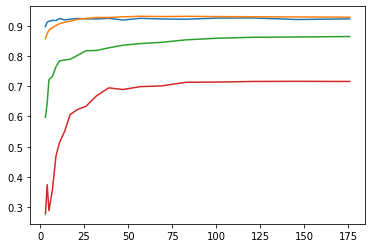

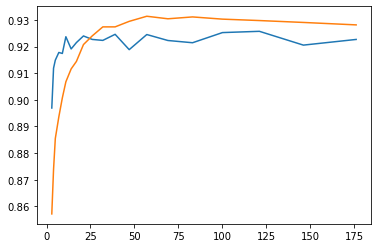

The best epoch of elmo is:  121
The best epoch of use is:  57
The best epoch of nnlm is:  176
The best epoch of gnew is:  146


In [13]:
early_stop = TCM.early_stop_searching()



In [11]:
for em in TCM.best_early_stop.keys():
    print(128* "=")
    print("The optimal stop epochs for model ", em,  " is ", TCM.best_early_stop[em])
print(128 * "=")

The optimal stop epochs for model  elmo  is  47
The optimal stop epochs for model  use  is  83
The optimal stop epochs for model  nnlm  is  176
The optimal stop epochs for model  gnew  is  176


## Test Set Evaluation

In [21]:
f1_test = TCM.evaluation_test_set()




Train on 8136 samples
Epoch 1/121
8136/8136 [==============================] - 1s 90us/sample - loss: -0.6561 - mean_absolute_error: 0.1925 - categorical_accuracy: 0.7069
Epoch 2/121
8136/8136 [==============================] - 0s 38us/sample - loss: -0.8461 - mean_absolute_error: 0.1308 - categorical_accuracy: 0.8815
Epoch 3/121
8136/8136 [==============================] - 0s 39us/sample - loss: -0.8834 - mean_absolute_error: 0.1081 - categorical_accuracy: 0.9046
Epoch 4/121
8136/8136 [==============================] - 0s 40us/sample - loss: -0.9000 - mean_absolute_error: 0.0951 - categorical_accuracy: 0.9163
Epoch 5/121
8136/8136 [==============================] - 0s 40us/sample - loss: -0.9106 - mean_absolute_error: 0.0864 - categorical_accuracy: 0.9224
Epoch 6/121
8136/8136 [==============================] - 0s 41us/sample - loss: -0.9170 - mean_absolute_error: 0.0799 - categorical_accuracy: 0.9282
Epoch 7/121
8136/8136 [==============================] - 0s 41us/sample - loss: -0.9

8136/8136 [==============================] - 0s 36us/sample - loss: -0.9815 - mean_absolute_error: 0.0194 - categorical_accuracy: 0.9839
Epoch 110/121
8136/8136 [==============================] - 0s 37us/sample - loss: -0.9817 - mean_absolute_error: 0.0191 - categorical_accuracy: 0.9843
Epoch 111/121
8136/8136 [==============================] - 0s 36us/sample - loss: -0.9817 - mean_absolute_error: 0.0191 - categorical_accuracy: 0.9843
Epoch 112/121
8136/8136 [==============================] - 0s 37us/sample - loss: -0.9819 - mean_absolute_error: 0.0190 - categorical_accuracy: 0.9846
Epoch 113/121
8136/8136 [==============================] - 0s 36us/sample - loss: -0.9819 - mean_absolute_error: 0.0189 - categorical_accuracy: 0.9846
Epoch 114/121
8136/8136 [==============================] - 0s 36us/sample - loss: -0.9819 - mean_absolute_error: 0.0188 - categorical_accuracy: 0.9850
Epoch 115/121
8136/8136 [==============================] - 0s 38us/sample - loss: -0.9820 - mean_absolute_er

8136/8136 [==============================] - 0s 31us/sample - loss: 0.6402 - mean_absolute_error: 0.1080 - categorical_accuracy: 0.8462
Epoch 40/176
8136/8136 [==============================] - 0s 32us/sample - loss: 0.6334 - mean_absolute_error: 0.1066 - categorical_accuracy: 0.8482
Epoch 41/176
8136/8136 [==============================] - 0s 31us/sample - loss: 0.6270 - mean_absolute_error: 0.1054 - categorical_accuracy: 0.8488
Epoch 42/176
8136/8136 [==============================] - 0s 32us/sample - loss: 0.6210 - mean_absolute_error: 0.1043 - categorical_accuracy: 0.8498
Epoch 43/176
8136/8136 [==============================] - 0s 32us/sample - loss: 0.6151 - mean_absolute_error: 0.1032 - categorical_accuracy: 0.8502
Epoch 44/176
8136/8136 [==============================] - 0s 32us/sample - loss: 0.6093 - mean_absolute_error: 0.1021 - categorical_accuracy: 0.8510
Epoch 45/176
8136/8136 [==============================] - 0s 31us/sample - loss: 0.6040 - mean_absolute_error: 0.1011 -

8136/8136 [==============================] - 0s 32us/sample - loss: 0.4720 - mean_absolute_error: 0.0742 - categorical_accuracy: 0.8708
Epoch 95/176
8136/8136 [==============================] - 0s 33us/sample - loss: 0.4707 - mean_absolute_error: 0.0739 - categorical_accuracy: 0.8709
Epoch 96/176
8136/8136 [==============================] - 0s 34us/sample - loss: 0.4694 - mean_absolute_error: 0.0737 - categorical_accuracy: 0.8707
Epoch 97/176
8136/8136 [==============================] - 0s 32us/sample - loss: 0.4682 - mean_absolute_error: 0.0734 - categorical_accuracy: 0.8708
Epoch 98/176
8136/8136 [==============================] - 0s 31us/sample - loss: 0.4669 - mean_absolute_error: 0.0731 - categorical_accuracy: 0.8719
Epoch 99/176
8136/8136 [==============================] - 0s 32us/sample - loss: 0.4658 - mean_absolute_error: 0.0729 - categorical_accuracy: 0.8717
Epoch 100/176
8136/8136 [==============================] - 0s 33us/sample - loss: 0.4647 - mean_absolute_error: 0.0726 

8136/8136 [==============================] - 0s 32us/sample - loss: 0.2367 - mean_absolute_error: 0.1573 - categorical_accuracy: 0.6910
Epoch 27/146
8136/8136 [==============================] - 0s 32us/sample - loss: 0.2349 - mean_absolute_error: 0.1561 - categorical_accuracy: 0.6935
Epoch 28/146
8136/8136 [==============================] - 0s 32us/sample - loss: 0.2332 - mean_absolute_error: 0.1546 - categorical_accuracy: 0.6936
Epoch 29/146
8136/8136 [==============================] - 0s 32us/sample - loss: 0.2315 - mean_absolute_error: 0.1534 - categorical_accuracy: 0.6981
Epoch 30/146
8136/8136 [==============================] - 0s 33us/sample - loss: 0.2300 - mean_absolute_error: 0.1522 - categorical_accuracy: 0.7002
Epoch 31/146
8136/8136 [==============================] - 0s 33us/sample - loss: 0.2284 - mean_absolute_error: 0.1510 - categorical_accuracy: 0.7035
Epoch 32/146
8136/8136 [==============================] - 0s 33us/sample - loss: 0.2270 - mean_absolute_error: 0.1500 -

8136/8136 [==============================] - 0s 32us/sample - loss: 0.2001 - mean_absolute_error: 0.1256 - categorical_accuracy: 0.7300
Epoch 82/146
8136/8136 [==============================] - 0s 33us/sample - loss: 0.2000 - mean_absolute_error: 0.1254 - categorical_accuracy: 0.7302
Epoch 83/146
8136/8136 [==============================] - 0s 31us/sample - loss: 0.1997 - mean_absolute_error: 0.1252 - categorical_accuracy: 0.7302
Epoch 84/146
8136/8136 [==============================] - 0s 32us/sample - loss: 0.1996 - mean_absolute_error: 0.1249 - categorical_accuracy: 0.7301
Epoch 85/146
8136/8136 [==============================] - 0s 32us/sample - loss: 0.1994 - mean_absolute_error: 0.1247 - categorical_accuracy: 0.7308
Epoch 86/146
8136/8136 [==============================] - 0s 34us/sample - loss: 0.1992 - mean_absolute_error: 0.1246 - categorical_accuracy: 0.7303
Epoch 87/146
8136/8136 [==============================] - 0s 33us/sample - loss: 0.1990 - mean_absolute_error: 0.1243 -

In [23]:
for em in f1_test.keys():
    print(128 * "=")
    print("The f1_score of ", em, " on test set with optimal hyperparameters: ")
    print("macro f1_score: ", f1_test[em][0],"; micro f1_score: ", f1_test[em][1] )

The f1_score of  elmo  on test set with optimal hyperparameters: 
macro f1_score:  0.9353244284408258 ; micro f1_score:  0.9353244284408258
The f1_score of  use  on test set with optimal hyperparameters: 
macro f1_score:  0.9356876075763586 ; micro f1_score:  0.9356876075763586
The f1_score of  nnlm  on test set with optimal hyperparameters: 
macro f1_score:  0.8641705193028264 ; micro f1_score:  0.8641705193028264
The f1_score of  gnew  on test set with optimal hyperparameters: 
macro f1_score:  0.7197255038699577 ; micro f1_score:  0.7197255038699577


The model `elmo` and `universal_string_embedding` have the performance very close

# Sentences Demonstration

In [12]:
test_phrases = ["Where is the nearest Starbucks ?", "i need to repair my car",
                "I need a ride from home", "I want to order something to eat", "can you activate",
                "I want a table in center city", "Ok that's it!"]
res = TCM.prediction('use', test_phrases)
print("Universal Standard Embedding: ")
for i in range(len(res)):
    print("The predicted topic of \"{} \" is : {}".format(test_phrases[i], res[i]))
res = TCM.prediction('elmo', test_phrases)
print(128 * "=")
print()

print("ELMo")
for i in range(len(res)):
    print("The predicted topic of \"{} \" is : {}".format(test_phrases[i], res[i]))

Universal Standard Embedding: 
The predicted topic of "Where is the nearest Starbucks ? " is : movie
The predicted topic of "i need to repair my car " is : restaurant
The predicted topic of "I need a ride from home " is : restaurant
The predicted topic of "I want to order something to eat " is : movie
The predicted topic of "can you activate " is : movie
The predicted topic of "I want a table in center city " is : uber
The predicted topic of "Ok that's it! " is : non-opening

ELMo
The predicted topic of "Where is the nearest Starbucks ? " is : coffee
The predicted topic of "i need to repair my car " is : movie
The predicted topic of "I need a ride from home " is : movie
The predicted topic of "I want to order something to eat " is : uber
The predicted topic of "can you activate " is : movie
The predicted topic of "I want a table in center city " is : movie
The predicted topic of "Ok that's it! " is : movie


# Conversation Demonstration

In [13]:
class Demo_Conversation(object):
    def __init__(self, model_cl):
        self.model_cl = model_cl
        self.classes_arr = ['auto', 'coffee', 'movie', 'non-opening', 'pizza','restaurant','uber']
        self.opening_response = {"auto" : "\tIt seems you want to repair your vehicle", \
                            "coffee" : "\tIt seems you want to order some coffee", \
                            "movie" : "\tIt seems you want to book movie tickets", \
                            "pizza" : "\tIt seems you want to order some pizza",\
                            "restaurant": "\tIt seems you want to book a table",\
                            "uber": "\tIt seems you want to take ride"}

    def inConversationDetected(self, embed = "elmo"):
        
        print("Conversation Test")
        print("Still working on it, not completed")
        print("Input \'~\' to stop")
        print(128 * "=")
        print("\tHello, what can I do for you?")
        print(128 * "-")
        userInput = ""
        current_topic = "non-opening";
        pre_topic = "non-opening"
        userInput = input()
        prediction = self.model_cl.prediction(embed, [userInput])[0]
        current_topic = prediction
        
        while current_topic == "non-opening":
            print("\t Sorry I can't understand what you mean")
            print(128 * "-")
            prediction = self.model_cl.prediction(embed, [userInput])[0]
            current_topic = prediction
            userInput = input()
        
        pre_topic = current_topic
        print("\ttopic predicted: ", current_topic)
        print("\tentering the scenario ", current_topic)
        print(self.opening_response[current_topic])
        
        
        while (userInput != "~"):  
            prediction = self.model_cl.prediction(embed, [userInput])[0]
            if prediction == "non-opening" or prediction == current_topic:
                print("\tno topic changing detected")
                userInput = input()
                continue
            
            print(128 * "-")
            current_topic = prediction
            print("\ttopic predicted: ", current_topic)
            print("\tentering the scenario ", current_topic)
            print(self.opening_response[current_topic])
            userInput = input()
        
        print("Goodbye, thank you for your attention")

In [14]:
DC = Demo_Conversation(TCM)

In [ ]:
DC.inConversationDetected()

Conversation Test
Still working on it, not completed
Input '~' to stop
	Hello, what can I do for you?
--------------------------------------------------------------------------------------------------------------------------------
i WANT A RIDE
	topic predicted:  coffee
	entering the scenario  coffee
	It seems you want to order some coffee
	no topic changing detected
I want a ride
	no topic changing detected
I am hungry
--------------------------------------------------------------------------------------------------------------------------------
	topic predicted:  movie
	entering the scenario  movie
	It seems you want to book movie tickets
